# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Ziqing Yan
#### Student ID: s3749857

Date: 3 October 2021

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: 
* sklearn
* gensim
* os
* numpy
* pandas
* matplotlib

## Introduction
In Task 2, I build a Bag-of-words model of count vector representation and models based on word embeddings. The latter contains FastText trained by job advertisement data, Word2Vec model trained by Google News dataset and Glove trained by the Wikipedia 2014 + Gigaword 5 corpus. Each model is trained by these three unweighted model and weighted model.
In Task 3, I build models for document classification based on the 6 models above except Bag-of-words model. Before that, I visualize the 

## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment, e.g.,
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from gensim.models.fasttext import FastText
import gensim.downloader as api
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

### 1. Bag-of-words model

Firstly, we need to load our files stored in Task 1 and get the word index, web index and description for each job advertisement.

In [2]:
# Load the files called vocab.txt
vocab = [] # store the vocabulary
with open("./vocab.txt") as f:
    lines = f.read().splitlines()
    for line in lines:
        # Just store vocab and don't need the index because the index is in order and we can generate them later easily
        vocab.append(line.split(":")[0]) 
f.close() # close the file
# Load the files called job_ads.txt
category = []
webIndex = []
description = []
with open("./job_ads.txt", encoding = "utf-8") as f:
    lines = f.read().splitlines()
    # Every 5 lines are correspond the information of one job advertisement, so split the list into many small list with the length of 5
    lists = [lines[i:i+5] for i in range(0, len(lines), 5)]
    for ad in lists: # traverse every information of job advertisement
        category.append(ad[1].split(": ")[1]) # get the category of every job advertisement
        webIndex.append(ad[2].split(": ")[1]) # get the web index of every job advertisement
        description.append(ad[4].split(": ")[1]) # get the description of every job advertisement
f.close() # close the file

Then, we need to save the count vector representation in a txt file called <span style="color: red">count_vectors.txt</span>.

In [3]:
# Save the count vector representation
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab) # create the CountVectorizer using the vocabulary
count_features = cVectorizer.fit_transform(description) # generate the count vector representation for documents

cVec_file = open("./count_vectors.txt", "w") # the output file 
for i in range(0, count_features.shape[0]): # traverse each description by index i
    cVec_file.write("#{}".format(webIndex[i])) # write the web index first
    for j in count_features[i].nonzero()[1]: # traverse the index whose corresponding value is not zero
        value = count_features[i][0,j] # get the count
        cVec_file.write(",{}:{}".format(j,value)) # write the word index and value in required format
    cVec_file.write("\n")
cVec_file.close() # close the file

### 2. Models based on word embeddings

#### 2.1. Unweighted vector representation

Firstly, we generate the FastText word embedding trained by the descriptions with a 200 embedding dimension.

In [16]:
tokenized_description = [des.split(" ") for des in description]

In [3]:
# Generate the FastText word embedding trained by the descriptions
tokenized_description = [des.split(" ") for des in description]
desFT = FastText(vector_size=200) # set the embedding dimension to 200
desFT.build_vocab(corpus_iterable = tokenized_description) # use the list of lists of tokens as the input of vocabulary
desFT.train(corpus_iterable = tokenized_description, epochs = desFT.epochs, 
            total_examples = desFT.corpus_count, total_words = desFT.corpus_total_words) # train the model
desFT_wv = desFT.wv # get the vectors of words

In [12]:
desFT.save("jobAds_FT.model")

Next, we load the Word2Vec model trained by Google News dataset.

In [4]:
# Load the Word2Vec word embedding trained by Google News dataset
pre_trained_W2V = api.load('word2vec-google-news-300')

We also load the word embedding of Glove trained by the Wikipedia 2014 + Gigaword 5 corpus.

In [6]:
# Load the Glove word embedding
glove = {} # for storing the word embedding vector
with open("glove.6B.100d.txt", encoding = "utf-8") as f: # load the model with 100 vector size
    for line in f:
        w, v = line.split(" ", maxsplit=1)# the word is on the left hand side of the first spece and the vector is on the another side,
                                           # so just split the line by the first space
        v = np.fromstring(v, "f", sep = " ") # turn the string into an array separated by space
        glove[w] = v # store the word and the corresponding vector

After getting these word embedding, we can build the embeddings machine learing models for document classification. Since it's a repetitive job, we create a function that can be reused. The following function can be also reused for generating weighted vector representation.

In [5]:
# The functioin is for building the model for document classification based on word embedding
def gen_docVecs(word_vectors, tokens, tfidf = []):
    document_vec = pd.DataFrame() # for storing the document vectors
    for i in range(0, len(tokens)):
        tokens_set = list(set(tokens[i])) # get the unique words in each description
        temp = pd.DataFrame() # the data frame for calculating vector representation of each document
        for j in range(0, len(tokens_set)): # traverse the tokens of the current description
            # If the word of the description is not in embeddings, some model will ignore it
            try:
                w = tokens_set[j]
                word_vector = word_vectors[w] # if the word doesn't appear in some embeddings, it will occur error and pass this loop
                if tfidf != []:
                    weight = float(tfidf[i][w])
                else:
                    weight = 1
                temp = temp.append(pd.Series(word_vector*weight), ignore_index = True) # store the weighted word vector
            except:
                pass
        document_vec = document_vec.append(temp.sum(), ignore_index = True) # compute the single document vector and store it
    return document_vec

It's time to build the unweighted vector representation of documents.

In [8]:
# Build unweighted vector representation of documents
desFT_dvs = gen_docVecs(desFT_wv,tokenized_description)
pre_trained_W2V_dvs = gen_docVecs(pre_trained_W2V,tokenized_description)
glove_dvs = gen_docVecs(glove,tokenized_description)

In [6]:
desFT_dvs = gen_docVecs(desFT_wv,tokenized_description)

In [7]:
desFT_dvs

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,51.364754,33.798065,8.499794,-12.805158,-50.741913,-63.722904,13.838670,-5.109086,-25.198244,-10.053062,...,19.908960,-60.037380,14.456323,3.257380,-23.754404,-7.829772,-19.640173,36.231010,-6.304070,-71.651154
1,-1.454721,13.672868,-12.717200,-4.817173,-10.192103,5.129083,5.395579,-8.192309,-4.857031,-4.683610,...,10.736674,-7.468447,-2.593787,2.322435,0.779316,2.329653,14.554407,11.906538,-5.493412,-5.599725
2,21.595463,31.053495,-14.849065,-6.274496,-14.825341,-41.118336,43.638588,-10.681334,35.510406,-12.059190,...,8.243451,-26.927557,-9.197647,-1.784509,-0.776888,12.987497,1.049215,17.816460,-32.437119,-15.089420
3,2.945102,18.067566,-11.211972,-0.043806,-17.179100,-7.491407,16.004936,-4.979954,17.416405,-4.845981,...,9.033760,-25.259182,-14.508782,19.556730,1.398509,14.191700,17.095900,27.628313,-17.165920,-22.496126
4,-8.936927,15.074389,-5.563939,9.842999,-29.887527,-10.433916,11.090103,8.864997,-10.713367,-6.464894,...,8.891855,-33.961727,0.470940,7.495345,-12.291453,3.935251,-4.403905,22.844013,-1.771902,-21.128008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,45.493275,53.503895,6.875514,-5.830832,-16.380728,-5.185170,43.877460,-3.636396,9.964568,-21.336298,...,34.536423,-40.612415,23.113480,-16.327559,19.514120,9.769470,-26.954525,24.155249,-26.533997,-19.616951
55445,137.042191,30.630920,35.952225,14.926739,-34.649746,-65.316734,64.487335,14.129924,-7.131819,-46.988815,...,42.209927,-125.120071,21.327412,24.538330,-41.284153,-2.834982,-49.151398,13.848951,-19.780272,-85.157341
55446,24.561539,35.707226,-4.950991,-28.249592,3.393724,3.009721,35.974533,13.842833,20.758358,-14.746267,...,51.922665,-19.493174,-6.530082,13.163420,1.688897,-4.799577,2.366052,-4.927737,-18.483723,-48.688160
55447,67.152130,32.149811,25.801304,-30.069427,-42.354416,-49.600990,39.957966,6.646093,-37.569286,-2.399138,...,24.331726,-76.784348,-9.380198,-2.507650,-16.392477,-9.863043,-30.443521,-1.591000,-10.414253,-50.108124


In [10]:
pre_trained_W2V_dvs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-3.354279,4.409393,-3.539497,2.745895,-3.503601,-0.919670,4.335865,-5.663864,6.294994,1.967102,...,-6.932373,8.514282,-10.623688,-0.468781,-5.134331,1.760330,6.038391,-0.901157,-0.838531,-4.224640
1,-1.266724,0.693857,-0.971405,0.409790,-1.282166,-0.747813,1.031311,-1.867340,-0.015137,0.836487,...,-0.215546,0.840179,-1.070923,0.966797,-0.132202,-0.323898,0.560791,-0.755341,0.098335,-0.996826
2,-4.807556,0.551636,-1.277416,1.882141,-1.083557,-1.519714,1.820866,-2.730639,4.312782,-0.568420,...,-2.477257,2.402481,-2.593948,1.669205,-0.729614,0.151535,2.564814,-2.956337,-1.335527,-2.267975
3,-3.197571,1.507507,-1.350807,1.228455,-0.291748,-0.915010,0.179749,-2.952610,1.581635,0.728302,...,-1.267181,1.250031,-0.713280,1.107498,-0.092438,1.595062,1.031555,-0.689804,-0.026337,-2.426453
4,-2.066956,0.733963,-1.432861,-0.566040,-0.164368,-0.849121,0.464020,-2.086730,1.354553,-0.130859,...,-1.924393,1.284081,-2.909065,0.397896,-1.912933,0.671326,2.257812,-0.099365,-1.258972,-0.742157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,-2.536758,2.159180,0.774261,4.177124,-3.379471,1.491253,4.175697,-3.885605,3.915710,1.103973,...,-6.758682,4.616891,-9.016998,-1.258240,0.780849,0.096142,3.081345,-1.079479,-0.742126,-3.172119
55445,-2.620621,12.472773,-3.865044,13.957230,-3.269388,-2.369141,8.836746,-15.389565,11.665363,4.516048,...,-19.606106,9.657043,-20.040751,-0.974979,-5.172047,-2.032391,11.067731,-4.635567,4.203915,-6.263058
55446,-2.640442,3.378075,0.880304,3.994415,-4.821838,0.567383,4.079105,-3.061430,4.292818,-2.224731,...,-6.547211,0.717701,-1.923370,1.869202,0.011173,3.010834,0.095923,-2.850864,2.505539,-1.355087
55447,-6.135651,3.155861,4.098099,6.157841,0.157535,-3.049751,4.254447,-9.976597,7.824593,1.982906,...,-9.034119,4.397018,-14.541168,-1.661084,-4.226723,-2.897202,3.977500,-7.534832,1.748705,-3.385223


In [11]:
glove_dvs

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.491500,5.978686,7.686144,9.216491,-0.838692,-9.950138,-13.199575,3.123564,-11.237437,19.554434,...,-25.680342,5.054967,4.993052,-1.463459,-18.910456,8.775468,-8.637283,-12.399957,45.020939,17.319355
1,0.639935,4.328330,1.080352,-2.362199,2.700812,-2.828263,-0.830626,2.646381,-1.612150,2.660058,...,0.687475,-1.344619,-0.880039,-1.128389,-3.979492,4.937317,-3.444410,-2.012058,8.213533,4.419847
2,1.962130,1.868975,1.654732,8.124942,-0.700032,-12.120690,-9.935669,1.124243,-3.376090,6.649408,...,-8.368406,3.916617,-5.182654,-9.551723,-3.113497,17.492331,-8.971733,-18.133020,24.821445,16.223043
3,-4.200242,-0.609617,3.331271,1.918706,0.012969,-2.853183,-6.680192,7.080572,-6.159173,5.673851,...,-8.805695,-1.036764,-5.314517,-1.008030,-0.095982,5.809570,-4.467122,-3.565438,15.324416,5.306979
4,1.111586,2.422882,1.391585,0.745154,2.394105,-1.845717,-2.662949,0.478365,-3.342186,5.093064,...,-1.468534,0.061256,2.756441,-2.378693,-1.400754,5.808495,-3.360594,-1.188042,9.802418,2.191259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,2.650417,12.376579,-3.233227,10.913268,-0.030459,-10.812555,-9.583711,5.813234,-1.593724,20.101204,...,-9.946582,2.390616,7.498462,-7.725482,-13.691257,13.984997,-6.774740,-14.297854,39.414715,18.478771
55445,10.974702,30.584810,-8.529701,19.920265,17.867348,4.245072,-29.984335,27.754223,-28.613892,8.374820,...,-24.216108,-19.599489,13.399947,-0.216654,-73.409744,8.481346,-21.920868,-22.740057,90.641953,33.481853
55446,0.414528,9.433581,-3.045338,4.078650,-5.746124,-0.850379,-17.417561,13.861917,1.347821,11.218361,...,-5.749063,-5.232068,0.595729,-0.989270,-20.514610,14.788015,-7.448860,-9.978266,29.831800,7.860268
55447,-3.359279,12.482922,5.565225,7.439692,15.095326,3.644841,-4.279558,17.226418,-23.878593,18.178061,...,-14.739244,-6.203285,-10.246217,16.943579,-37.853386,12.666732,-20.800505,-29.604126,55.623638,16.711849


#### 2.2. Weighted vector representation

This time, we build weighted vector representations using the previous function gen_docVecs().

Firstly, we need to generate the weights of words of each description.

In [18]:
# Generate the weighted of words of each description
tfidf_weights = [] # for storing the weight of words in each description(each description correspond one dictionary)
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab) # create the TfidfVectorizer using the vocabulary
tfidf_features = tVectorizer.fit_transform(description) # generate the tfidf vector representation for documents
for i in range(0, tfidf_features.shape[0]): # traverse each description by index i
    weight_dict = {} # for storing the weights of words in one description
    for j in tfidf_features[i].nonzero()[1]: # traverse the index whose corresponding value is not zero
        value = tfidf_features[i][0,j] # get the weight
        weight_dict[vocab[j]] = value # add the weight to the corresponding word
    tfidf_weights.append(weight_dict) # append the weights of words for one description

After that, we can use the weights we get to build the weighted model.

In [13]:
# Build weighted vector representation of documents
weighted_desFT_dvs = gen_docVecs(desFT_wv,tokenized_description, tfidf_weights)
weighted_pre_trained_W2V_dvs = gen_docVecs(pre_trained_W2V,tokenized_description, tfidf_weights)
weighted_glove_dvs = gen_docVecs(glove,tokenized_description, tfidf_weights)

In [20]:
weighted_pre_trained_W2V_dvs = gen_docVecs(pre_trained_W2V,tokenized_description, tfidf_weights)

In [14]:
# Train the classification model with Word2Vec model trained by Google News dataset
seed = 1

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(desFT_dvs, category, test_size=test_size, random_state=seed)

model = LogisticRegression(max_iter = 100,random_state=seed) # create the model of Logistic Regression, set max_iter to 100 
                                                            # because it is too computationally expensive and some experiments show that
                                                            # the accuracy is affected slightly
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.8471501174927591


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
pickle.dump(model, open('JobAdsFT_LR.pkl', 'wb'))

In [33]:
loaded_model = pickle.load(open('W2V_model.pkl', "rb"))
y_predict = loaded_model.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.8611946007978578


In [14]:
weighted_desFT_dvs

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,6.287802,5.512249,1.435345,-0.972660,-6.559556,-2.282280,0.655004,0.627783,-5.301485,1.111004,...,1.268549,-3.095878,-0.885762,-2.644469,1.238159,1.020940,-0.810748,0.172074,1.632283,-6.732616
1,3.614675,0.241316,-0.716300,-0.281757,-4.399211,1.145944,0.897818,-1.332625,-0.957119,-0.237830,...,-0.900649,-1.601832,-2.005965,0.329793,1.476125,1.945451,2.194402,2.686589,-2.025289,-1.394282
2,6.969299,3.466263,-1.046897,-1.004223,-5.555007,-2.801608,6.738991,-1.037741,1.796704,-2.171811,...,0.571442,-2.363197,-1.221462,-1.329545,3.143866,3.086636,-2.819497,0.538298,-2.095714,-2.593672
3,2.771366,3.259103,-1.383648,-0.460337,-3.366154,-2.064963,5.243468,1.400774,1.492228,-0.695006,...,1.269255,-2.511812,-3.190459,-0.366016,1.142330,3.343062,2.071905,2.602165,-1.866115,-2.487688
4,2.215889,2.559202,-0.595868,0.593520,-4.302380,-2.098720,4.300276,1.478806,-1.877908,-0.015525,...,1.517114,-4.097753,-1.099292,0.220649,-1.377809,2.265628,-0.190360,2.712536,-0.358193,-3.399527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,5.652891,5.837942,2.264439,-1.174867,-1.010034,0.412470,4.036075,-0.837399,-3.022236,0.366165,...,3.585571,-1.759553,0.352360,-2.768996,4.410260,1.604203,-1.738125,-0.744211,-1.071983,-3.910155
55445,8.166843,1.581306,4.058153,1.714567,-2.522902,-3.896348,1.947080,-0.108646,-2.975532,-2.376696,...,1.579759,-3.713225,-0.148560,-0.469540,0.026909,2.154641,-2.414606,-0.687496,0.183414,-4.382834
55446,4.494393,1.643453,1.614213,-4.292592,0.700427,0.348342,3.036405,2.797620,0.085033,0.292854,...,3.203881,-2.457669,-2.407743,-0.525416,1.230439,1.318716,-0.579329,-0.526371,3.031796,-4.999216
55447,5.227797,1.987442,4.640125,-1.302510,-3.860184,-3.690072,3.071737,-0.127538,-2.589777,0.820890,...,1.400895,-3.920164,-2.293430,-1.362429,-1.024821,1.688463,-0.606729,-3.946479,1.284394,-3.751209


In [15]:
weighted_pre_trained_W2V_dvs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.194136,0.378888,-0.302106,0.240550,-0.262467,-0.017001,0.418804,-0.415764,0.570363,0.138028,...,-0.634122,0.729725,-0.940160,-0.161725,-0.463975,0.094369,0.435930,-0.073329,-0.107830,-0.349539
1,-0.148163,0.187331,-0.137678,0.018586,-0.152849,-0.182455,0.273130,-0.397274,0.041626,0.090608,...,-0.111548,0.179762,-0.168483,0.135643,0.007094,-0.122795,0.176313,-0.140497,0.088943,-0.152709
2,-0.487147,0.105829,-0.164974,0.305996,0.014451,-0.134132,0.337538,-0.221302,0.693861,-0.074488,...,-0.308488,0.378590,-0.257579,0.271808,-0.101349,0.146418,0.388671,-0.437618,-0.181753,-0.377023
3,-0.538770,0.083071,-0.210928,0.181207,0.185175,-0.246803,-0.023834,-0.528085,0.169433,0.116722,...,-0.231075,0.127156,-0.084979,0.126949,-0.067000,0.173794,0.072192,-0.173871,-0.121000,-0.437939
4,-0.369484,0.022843,-0.202470,-0.114035,-0.033417,-0.127719,0.055190,-0.444216,0.144475,-0.027211,...,-0.308031,0.158673,-0.474113,0.086150,-0.275509,0.085143,0.290068,-0.079551,-0.237483,-0.159857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,-0.168004,0.145053,0.174515,0.411269,-0.202468,0.087998,0.390498,-0.382404,0.239665,0.117575,...,-0.566126,0.545506,-0.929357,-0.109916,0.011442,0.057445,0.327480,-0.126781,-0.123817,-0.130818
55445,0.030735,0.651979,-0.244134,0.765271,-0.065219,-0.193001,0.394194,-0.743777,0.409119,0.107722,...,-0.918860,0.411035,-1.009135,-0.011103,-0.284326,-0.141868,0.446594,-0.217995,0.345695,-0.200172
55446,-0.188870,0.168896,0.135763,0.324180,-0.366568,-0.026319,0.357389,-0.142711,0.270676,-0.218469,...,-0.680314,0.049305,-0.158141,0.299637,-0.002732,0.248173,0.010806,-0.375263,0.290822,-0.029164
55447,-0.379930,0.193580,0.328752,0.500950,0.104839,-0.199820,0.263094,-0.688348,0.423102,0.136071,...,-0.545586,0.327133,-0.965387,-0.092205,-0.354036,-0.239954,0.090197,-0.516905,0.215529,-0.069229


In [16]:
weighted_glove_dvs

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.066708,0.269880,0.673453,0.829049,-0.181020,-1.089805,-1.377016,0.111248,-0.916845,1.590349,...,-2.695921,0.201893,0.679422,0.302129,-1.609581,0.806604,-0.296472,-0.955664,3.764083,1.276523
1,-0.255227,0.799737,0.165812,-0.572332,0.600142,-0.743365,-0.385363,0.409056,-0.409538,0.604008,...,0.524650,-0.401947,-0.278989,-0.281309,-0.798728,1.135304,-0.532691,-0.577114,1.820121,0.791414
2,0.424571,-0.017948,0.122778,0.985270,-0.119955,-1.546356,-1.089859,0.234149,-0.378970,0.650234,...,-1.195016,0.465082,-0.871966,-0.944868,-0.215998,1.904673,-0.443287,-1.762251,2.757532,1.785175
3,-0.796986,-0.316604,0.476724,-0.342101,-0.123407,-0.579722,-0.669904,1.484237,-0.877981,1.070108,...,-1.132899,-0.087026,-0.805602,0.166599,0.492113,1.036742,-0.340257,-0.266479,1.668729,0.641409
4,0.100696,0.042462,0.438559,-0.314715,0.234485,-0.449020,-0.229622,0.489641,-0.637548,1.020849,...,-0.282862,0.107715,0.461684,0.032862,0.440866,1.189280,-0.143084,0.088839,1.199324,0.117037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,0.573694,1.041396,-0.216610,0.662108,-0.218641,-1.039889,-0.818709,0.991784,-0.224122,2.284659,...,-1.109509,0.179263,0.703121,-0.416868,-0.959454,1.343745,-0.318964,-1.243101,3.230983,1.724772
55445,0.303220,1.004669,-0.831381,0.106645,0.635870,0.213100,-1.412733,1.314324,-1.394186,0.219117,...,-1.468015,-1.186516,0.902828,-0.176096,-3.345750,0.719031,-1.198169,-1.141536,3.108524,1.589892
55446,0.077080,0.657384,-0.250782,-0.079055,-0.679685,0.404857,-1.435674,1.770477,0.155536,1.316593,...,-0.541289,-0.374063,-0.006374,0.188712,-1.569368,1.574270,-0.494462,-0.834350,2.370407,0.556952
55447,0.029229,0.954256,-0.244882,0.103802,0.584369,0.456640,-0.080358,1.699725,-1.736837,1.302251,...,-1.499420,-0.786053,-0.791256,2.244484,-2.680526,0.538327,-0.882550,-1.566002,3.161773,0.622134


## Task 3. Job Advertisement Classification

### 1. Language model comparisons

In this section, we will first look at the distribution of document using visualization. Then, we can build classification models of Logistic Regression and evaluate them. The method of evaluation is the mean accuracy of 5-fold cross validation, which is robust. The dimension of the vector representation will be reduced using t-SNE for visualization. Firstly, let's create a function that can be reused to reduce the dimension and visualization.

In [8]:
# The function is for plotting the result of t-SNE
def plotTSNE(labels,features): # label is a Series and features is a numpy array
    uni_categories = sorted(labels.unique())
    size = int(len(features) * 0.1) # t-SNE is computationally expensive, so we select 10% of data implement
    np.random.seed(0) # set the seed
    indices = np.random.choice(range(0, len(features)), size=size, replace=False)
    reduced_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['firebrick', 'cyan', 'darkviolet', 'pink', 'green', 'midnightblue', 'orange', 'darkgrey']
    for i in range(0,len(uni_categories)):
        points = reduced_features[(labels[indices] == uni_categories[i])] # get the point whose dimension has reduced to 2 dimension
        plt.scatter(points[:, 0], points[:, 1], s=20, c=colors[i], label=uni_categories[i]) # plot the points
    plt.title("Feature vector for each description, projected on 2 dimensions.",
              fontdict=dict(fontsize=14))
    plt.legend()
    plt.show()

In [10]:
seed = 0 # decline a seed that can be changed easily

#### 1.1. Build the classification model with FastText trained by description

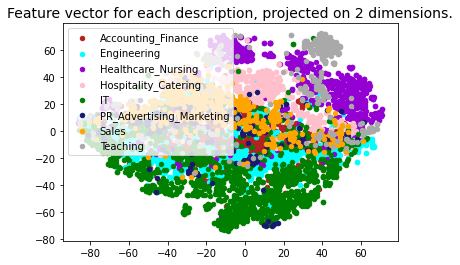

In [19]:
# If there is any nan in the row of vector presentatino, delete the row and its corresponding label(just in case there is any nan)
nan_position = np.isnan(desFT_dvs).any(axis=1) # find the row that contains nan
desFT_dvs = desFT_dvs.loc[-nan_position,:] # remove the row that contains nan
temp_category = pd.Series(category)[-nan_position] # remove the corresponding category
temp_category.index = np.array(range(0,len(temp_category))) # reset the index from 0 to the length
# Reduce the dimension and visualization
features = desFT_dvs.to_numpy() # transform the dataframe to array
plotTSNE(pd.Series(category),features) # visualize the result

In [11]:
# Train the classification model with FastText trained by description
model = LogisticRegression(max_iter = 100,random_state=seed) # create the model of Logistic Regression, set max_iter to 100 
                                                            # because it is too computationally expensive and some experiments show that
                                                            # the accuracy is affected slightly
scores = cross_val_score(model, desFT_dvs, category, cv = 5, scoring='accuracy') # implement 5-fold cross validation
scores.mean() # calculate the mean accuracy

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

0.8448663079383699

#### 1.2. Build the classification model with Word2Vec model trained by Google News dataset

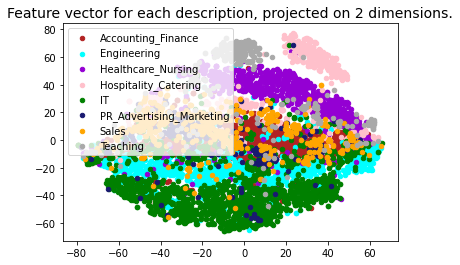

In [21]:
# If there is any nan in the row of vector presentatino, delete the row and its corresponding label(just in case there is any nan)
nan_position = np.isnan(pre_trained_W2V_dvs).any(axis=1) # find the row that contains nan
pre_trained_W2V_dvs = pre_trained_W2V_dvs.loc[-nan_position,:] # remove the row that contains nan
temp_category = pd.Series(category)[-nan_position] # remove the corresponding category
temp_category.index = np.array(range(0,len(temp_category))) # reset the index from 0 to the length
# Reduce the dimension and visualization
features = pre_trained_W2V_dvs.to_numpy() # transform the dataframe to array
plotTSNE(pd.Series(category),features) # visualize the result

In [22]:
# Train the classification model with Word2Vec model trained by Google News dataset
model = LogisticRegression(max_iter = 100,random_state=seed) # create the model of Logistic Regression, set max_iter to 100 
                                                            # because it is too computationally expensive and some experiments show that
                                                            # the accuracy is affected slightly
scores = cross_val_score(model, pre_trained_W2V_dvs, category, cv = 5, scoring='accuracy') # implement 5-fold cross validation
scores.mean() # calculate the mean accuracy

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

0.8535409846116766

#### 1.3. Build the classification model with Glove trained by the Wikipedia 2014 + Gigaword 5 corpus

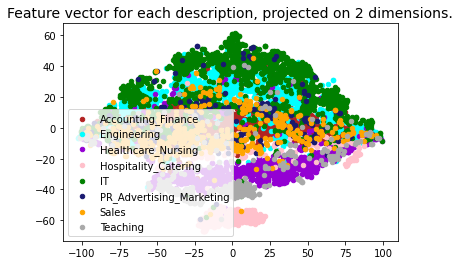

In [23]:
# If there is any nan in the row of vector presentatino, delete the row and its corresponding label(just in case there is any nan)
nan_position = np.isnan(glove_dvs).any(axis=1) # find the row that contains nan
glove_dvs = glove_dvs.loc[-nan_position,:] # remove the row that contains nan
temp_category = pd.Series(category)[-nan_position] # remove the corresponding category
temp_category.index = np.array(range(0,len(temp_category))) # reset the index from 0 to the length
# Reduce the dimension and visualization
features = glove_dvs.to_numpy() # transform the dataframe to array
plotTSNE(pd.Series(category),features) # visualize the result

In [25]:
# Train the classification model with Word2Vec model trained by Google News dataset
model = LogisticRegression(max_iter = 100,random_state=seed) # create the model of Logistic Regression, set max_iter to 100 
                                                            # because it is too computationally expensive and some experiments show that
                                                            # the accuracy is affected slightly
scores = cross_val_score(model, glove_dvs, temp_category, cv = 5, scoring='accuracy') # implement 5-fold cross validation
scores.mean() # calculate the mean accuracy

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

0.8176881955415893

#### 1.4. Build the classification model by previous three models with weight

Weighted In-house FastText: The visualization of 2-dimensions document vector using t-SNE 


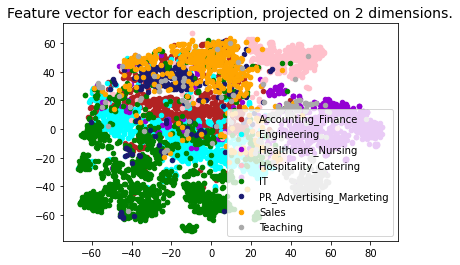

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Mean accurary of 5-fold cross validation: 0.8563903627190156



Weighted Pre-trained Word2Vec: The visualization of 2-dimensions document vector using t-SNE 


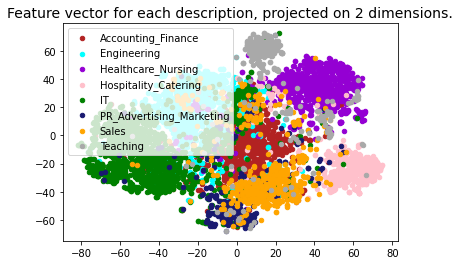

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Mean accurary of 5-fold cross validation: 0.8618729793479286



Weighted Pretrained GloVe: The visualization of 2-dimensions document vector using t-SNE 


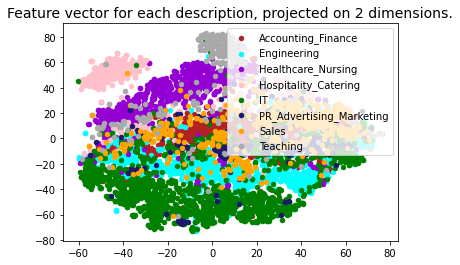

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Mean accurary of 5-fold cross validation: 0.8317190847297393





D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
%matplotlib inline

models = [weighted_desFT_dvs, weighted_pre_trained_W2V_dvs, weighted_glove_dvs] # for storing three weighted models
names = ["Weighted In-house FastText","Weighted Pre-trained Word2Vec","Weighted Pretrained GloVe"] # the names of these models
for i in range(0,len(models)): # traverse the three models
    model = models[i]
    name = names[i]
    nan_position = np.isnan(model).any(axis=1) # find the row that contains nan
    model = model.loc[-nan_position, :] # remove the row that contains nan
    temp_category = pd.Series(category)[-nan_position] # remove the corresponding category
    temp_category.index = np.array(range(0,len(temp_category))) # reset the index from 0 to the length

    features = model.to_numpy() # transform the dataframe to array
    print(name + ": The visualization of 2-dimensions document vector using t-SNE ")
    plotTSNE(temp_category,features) # visualize the result
    
    LR = LogisticRegression(max_iter = 100,random_state=seed) # create the model of Logistic Regression, set max_iter to 100 
                                                            # because it is too computationally expensive and some experiments show that
                                                            # the accuracy is affected slightly
    scores = cross_val_score(LR, model, temp_category, cv = 5, scoring='accuracy') # implement 5-fold cross validation
    print("Mean accurary of 5-fold cross validation: " + str(scores.mean())) # calculate the mean accuracy
    print("\n\n")

As the pictures and average accuracys of the 6 models show above, the model of weighted pre-trained Word2Vec is perform the best with the average accuracy of 0.8618. The unweighted pre-trained Word2Vec and weighted In-house FastText also perform well with the average accuracy of around 0.85. Moreover, the weighted models performe better that the unweighted models overall.

## Summary
If only considering the description as the data to train the model, the weighted models performe better that the unweighted models overall.